In [10]:
# !ls checkpoints/video_local

In [11]:
# !python utils/prepare_weights.py integrate checkpoints/video_local/best-model-v1.ckpt checkpoints/video_global/best-model-v1.ckpt configs/video_uni_v15/uni_v15.yaml checkpoints/video_uni_v15.ckpt

In [8]:
import torch
key = 'model.diffusion_model.time_embed.0.weight'
device = 'cuda'
local_weights = torch.load('checkpoints/testinglocal/best-model-v1.ckpt', map_location=device)
global_weights = torch.load('checkpoints/testingglobal/best-model.ckpt', map_location=device)

l= local_weights['state_dict'][key]
g = global_weights['state_dict'][key]

In [9]:
print(l.shape,g.shape)
print(l.equal(g))
max_diff = torch.max(torch.abs(l - g))
print("Maximum absolute difference:", max_diff)

torch.Size([1280, 320]) torch.Size([1280, 320])
True
Maximum absolute difference: tensor(0., device='cuda:0')


In [8]:
# !python utils/debug_weights.py integrate checkpoints/testinglocal/best-model.ckpt checkpoints/testingglobal/best-model.ckpt configs/video_uni_v15/uni_v15.yaml checkpoints/testing_uni_v15.ckpt

In [12]:
import math
from pytorch_msssim import ms_ssim
from torchvision import transforms
import torch
from PIL import Image

psnr_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    lambda x: x * 255
])

def psnr(a: torch.Tensor, b: torch.Tensor, max_val: int = 255) -> float:
    return 20 * math.log10(max_val) - 10 * torch.log10((a - b).pow(2).mean())


/data/maryam.sana/anaconda3/envs/unicontrol/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
# Directories
image_folder = 'data/test_data/'
predicted_folder = 'data/video_uninet_preds/'

# List all image files
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])
predicted_files = sorted([f for f in os.listdir(predicted_folder) if f.endswith('.png')])

# Ensure the directories have the same number of files
assert len(image_files) == len(predicted_files), "The number of files in the two directories must be the same"

psnr_values = []
ms_ssim_values = []

# Process each image file
for orig_file, pred_file in zip(image_files, predicted_files):
    orig_path = os.path.join(image_folder, orig_file)
    pred_path = os.path.join(predicted_folder, pred_file)
    
    # Load images
    orig_img = Image.open(orig_path).convert("RGB")
    pred_img = Image.open(pred_path).convert("RGB")
    
    # Apply transformations
    orig_tensor = psnr_transform(orig_img)
    pred_tensor = psnr_transform(pred_img)
    
    # Calculate PSNR
    psnr_value = psnr(orig_tensor, pred_tensor)
    psnr_values.append(psnr_value)
    
    # Calculate MS-SSIM
    ms_ssim_value = ms_ssim(orig_tensor.unsqueeze(0), pred_tensor.unsqueeze(0), data_range=255, size_average=True).item()
    ms_ssim_values.append(ms_ssim_value)
    
    print(f"PSNR for {orig_file} and {pred_file}: {psnr_value}")
    print(f"MS-SSIM for {orig_file} and {pred_file}: {ms_ssim_value}")

# Calculate average PSNR and MS-SSIM
avg_psnr = np.mean(psnr_values)
avg_ms_ssim = np.mean(ms_ssim_values)

print(f"Average PSNR: {avg_psnr}")
print(f"Average MS-SSIM: {avg_ms_ssim}")

## Training statictics plots

In [5]:
import re
import numpy as np
import matplotlib.pyplot as plt

# Function to extract values from the log file
def extract_values(log_file):
    with open(log_file, 'r') as file:
        lines = file.readlines()
    
    epoch_losses = {}
    
    for line in lines:
        if "Epoch" in line and "loss=" in line:
            epoch_match = re.search(r'Epoch (\d+)', line)
            loss_epoch_match = re.search(r'train/loss_epoch=([\d.]+)', line)
            loss_simple_epoch_match = re.search(r'train/loss_simple_epoch=([\d.]+)', line)
            loss_vlb_epoch_match = re.search(r'train/loss_vlb_epoch=([\d.]+)', line)
            
            if epoch_match and loss_epoch_match and loss_simple_epoch_match and loss_vlb_epoch_match:
                epoch = int(epoch_match.group(1))
                loss_epoch = float(loss_epoch_match.group(1))
                loss_simple_epoch = float(loss_simple_epoch_match.group(1))
                loss_vlb_epoch = float(loss_vlb_epoch_match.group(1))
                
                if epoch not in epoch_losses:
                    epoch_losses[epoch] = {
                        'loss_epoch': [],
                        'loss_simple_epoch': [],
                        'loss_vlb_epoch': [],
                    }
                
                epoch_losses[epoch]['loss_epoch'].append(loss_epoch)
                epoch_losses[epoch]['loss_simple_epoch'].append(loss_simple_epoch)
                epoch_losses[epoch]['loss_vlb_epoch'].append(loss_vlb_epoch)
    
    return epoch_losses

# Calculate averages for each epoch
def calculate_averages(epoch_losses):
    avg_losses = {
        'epochs': [],
        'avg_loss_epoch': [],
        'avg_loss_simple_epoch': [],
        'avg_loss_vlb_epoch': []
    }
    
    for epoch, losses in epoch_losses.items():
        avg_losses['epochs'].append(epoch)
        avg_losses['avg_loss_epoch'].append(np.mean(losses['loss_epoch']))
        avg_losses['avg_loss_simple_epoch'].append(np.mean(losses['loss_simple_epoch']))
        avg_losses['avg_loss_vlb_epoch'].append(np.mean(losses['loss_vlb_epoch']))
    
    return avg_losses

# Function to plot the values
def plot_losses(avg_losses):
    epochs = avg_losses['epochs']
    avg_loss_epoch = avg_losses['avg_loss_epoch']
    avg_loss_simple_epoch = avg_losses['avg_loss_simple_epoch']
    avg_loss_vlb_epoch = avg_losses['avg_loss_vlb_epoch']
    
    fig, axs = plt.subplots(3, 1, figsize=(6, 8))
    
    axs[0].plot(epochs, avg_loss_epoch, label='Average Loss Epoch')
    axs[0].set_title('Total Loss vs Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss Epoch')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(epochs, avg_loss_simple_epoch, label='Average Loss Simple Epoch', color='orange')
    axs[1].set_title('Reconstruction Loss vs Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss Simple Epoch')
    axs[1].legend()
    axs[1].grid(True)
    
    axs[2].plot(epochs, avg_loss_vlb_epoch, label='Average Loss VLB Epoch', color='green')
    axs[2].set_title('VLB Loss vs Epochs')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Loss VLB Epoch')
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()


In [ ]:
# ALl Conditions Local Adapter Training 
log_file = 'slurm_logs/slurm-106202.out'
epoch_losses = extract_values(log_file)
avg_losses = calculate_averages(epoch_losses)
plot_losses(avg_losses)

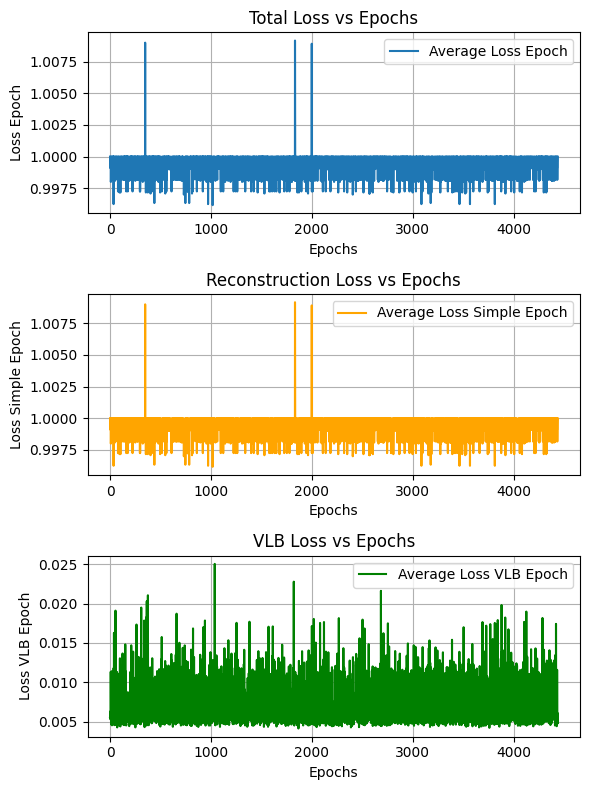

In [6]:
# Video Data Local Adapter Training
# log_file = 'slurm_logs/slurm-106384.out'
log_file = 'slurm-106478.out'
epoch_losses = extract_values(log_file)
avg_losses = calculate_averages(epoch_losses)
plot_losses(avg_losses)

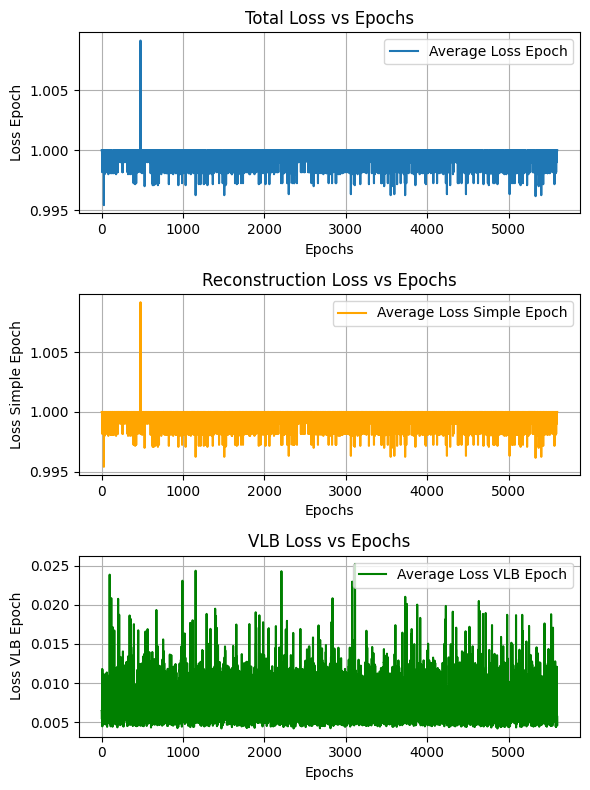

In [7]:
#Video Data Global Adapter Training
log_file = 'slurm-106479.out'
epoch_losses = extract_values(log_file)
avg_losses = calculate_averages(epoch_losses)
plot_losses(avg_losses)

In [4]:
#All conditions Global Adapter Training
log_file = 'slurm-106459.out'
epoch_losses = extract_values(log_file)
avg_losses = calculate_averages(epoch_losses)
# plot_losses(avg_losses)